[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239934-lesson-1-parallelization)

# Search Agent

Let's implement web searching abilities for agent to get relevant context from web! And add several sources to browse asynchronously!

In [126]:
%%capture --no-stderr
%pip install -U  langgraph tavily-python wikipedia langchain_openai langchain_community langgraph_sdk

In [127]:


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Parallel nodes execution
Small recup from previous lecture

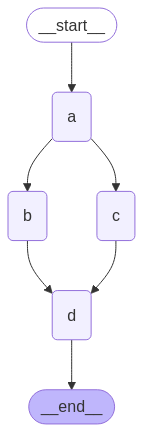

In [139]:
import operator
from typing import Any, Annotated

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

We over-write state, as expected.

In [129]:
graph.invoke({"state": []})
# Q: What is the output?
# Q: What is the order of the reduction?
# Q: Nodes B and C runs in the same CPU?

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

## Tavily
[Tavily](https://tavily.com/) is one nice option to implement web search tools., but ensure your `TAVILY_API_KEY` is set.

In [130]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")

In [131]:
from langchain_community.tools import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3) # Q: How it works? Guesses?
search_docs = tavily_search.invoke("What is langgraph?")
search_docs

[{'title': 'What is LangGraph? - Analytics Vidhya',
  'url': 'https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/',
  'content': 'To sum up, LangGraph is a major advancement in the development of AI agents. It enables developers to push the limits of what’s possible with AI agents by eliminating the shortcomings of earlier systems and offering a flexible, graph-based framework for agent construction and execution. LangGraph is positioned to influence the direction of artificial intelligence significantly in the future. [...] LangGraph is a library built on top of Langchain that is designed to facilitate the creation of cyclic graphs for large language model (LLM) – based AI agents.\nIt views agent Objective Points about LangGraph and workflows as cyclic graph topologies, allowing for more variable and nuanced agent behaviors than linear execution models. [...] Frameworks such as LangGraph are becoming increasingly important as AI develops. LangGraph is maki

## Research Agent with Search

Let's build an agent which before generation an answer goes to web for relevant context

In [132]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo")

In [133]:
class State(TypedDict):
    question: str
    answer: str
    context: str

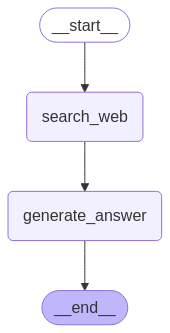

In [134]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.tools import TavilySearchResults

def search_web(state):
    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": formatted_search_docs}

def generate_answer(state):
    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, context=context)
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_web")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [135]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result['answer'].content

"Nvidia's Q2 2024 earnings were impressive, with the company reporting a revenue of $30.04 billion, more than doubling from the same period the previous year. The net income also more than doubled to $16.6 billion from the year-ago period. Data center revenue particularly stood out, reaching $26.3 billion, up 154% from the previous year's Q2. Despite these strong financial results, Nvidia's stock declined after hours, as mentioned in a Forbes article."

In [136]:
result['context']

'<Document href="https://www.investopedia.com/nvidia-earnings-live-coverage-q2-fy2025-8703414">\nAugust 28, 2024 04:31 PM EDT\nNvidia reported fiscal second-quarter earnings and revenue that exceeded analysts’ estimates, as data center revenue reached another record high, driven by surging demand for artificial intelligence.\nThe AI chipmaker posted second-quarter revenue of $30.04 billion, more than doubling from the same period a year\xa0ago. Net\xa0income at $16.6 billion also more than doubled from the year-ago period. [...] August 28, 2024 04:50 PM EDT\nHere’s how Nvidia reported its second-quarter revenue and revenue growth by business segment:\n\nData center: $26.3 billion, up 16% from Q1 and 154% from last year’s Q2\nGaming and AI PC: $2.9 billion, up 9% from Q1 and 16% from last year’s Q2\nProfessional visualization: $454 million, up 6% from Q1 and 20% from last year’s Q2\nAutomotive and robotics: $346 million, up 5% from Q1 and 37% from last year’s Q2 [...] August 28, 2024 04

## Task
Add wikipedia tool as a parallel tool call to tavily
https://python.langchain.com/docs/integrations/document_loaders/wikipedia/

In [137]:
# Q: How answer changed?
# Q: Can you come up with question which can not be solved fully without both search tools?